In [110]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


In [111]:
df = pd.read_csv('ramen-ratings.csv')

##Exploring the Data

In [112]:
df.isna().sum()

Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2539
dtype: int64

In [113]:
shape= df.shape
print("Rows: ",shape[0])
print("Columns: ",shape[1])


Rows:  2580
Columns:  7


In [114]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


In [115]:
df.describe()

,Review #
count,2580.000000
mean,1290.500000
std,744.926171
min,1.000000
25%,645.750000
50%,1290.500000
75%,1935.250000
max,2580.000000


### Let's convert this dataset.

In [116]:
# Let's Convert Stars and Top Ten
df['Stars']=pd.to_numeric(df['Stars'], errors='coerce')

In [117]:
df.isna().sum()

Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          3
Top Ten     2539
dtype: int64

In [118]:
#Split the dataset
df[['Top Ten Rating Year','Top Ten Rating']] = df['Top Ten'].str.split(" ",expand=True)
df['Top Ten Rating']= df['Top Ten Rating'].str.lstrip('#')
df['Top Ten Rating Year']=pd.to_numeric(df['Top Ten Rating Year'], errors='coerce')
df['Top Ten Rating']=pd.to_numeric(df['Top Ten Rating'], errors='coerce')


In [119]:
df.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten,Top Ten Rating Year,Top Ten Rating
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN,NaN,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00,NaN,NaN,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN,NaN,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN,NaN,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN,NaN,NaN


In [120]:
df.isna().sum()

Review #                  0
Brand                     0
Variety                   0
Style                     2
Country                   0
Stars                     3
Top Ten                2539
Top Ten Rating Year    2543
Top Ten Rating         2543
dtype: int64

In [121]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()


Style                     2
Stars                     3
Top Ten                2539
Top Ten Rating Year    2543
Top Ten Rating         2543
dtype: int64

In [122]:
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    print('{} - {}'.format(col,round(pct_missing*100)))

Review # - 0.0
Brand - 0.0
Variety - 0.0
Style - 0.0
Country - 0.0
Stars - 0.0
Top Ten - 98.0
Top Ten Rating Year - 99.0
Top Ten Rating - 99.0


In [123]:
df.Country.value_counts()

Japan            352
USA              323
South Korea      309
Taiwan           224
Thailand         191
China            169
Malaysia         156
Hong Kong        137
Indonesia        126
Singapore        109
Vietnam          108
UK                69
Philippines       47
Canada            41
India             31
Germany           27
Mexico            25
Australia         22
Netherlands       15
Myanmar           14
Nepal             14
Pakistan           9
Hungary            9
Bangladesh         7
Colombia           6
Cambodia           5
Brazil             5
Holland            4
Fiji               4
Poland             4
Sarawak            3
Finland            3
Sweden             3
Dubai              3
Ghana              2
Estonia            2
United States      1
Nigeria            1
Name: Country, dtype: int64

In [124]:
df[df['Country']== 'Japan'].describe()

,Review #,Stars,Top Ten Rating Year,Top Ten Rating
count,352.000000,352.000000,6.000000,6.000000
mean,1375.928977,3.981605,2013.000000,5.333333
std,774.640726,0.913755,1.264911,2.160247
min,12.000000,0.000000,2012.000000,3.000000
25%,688.500000,3.500000,2012.000000,4.000000
50%,1391.500000,4.000000,2012.500000,5.000000
75%,2002.250000,4.750000,2013.750000,6.000000
max,2580.000000,5.000000,2015.000000,9.000000


In [125]:
##75 % of the Top Ten Rating fall in to the top ten rating. 

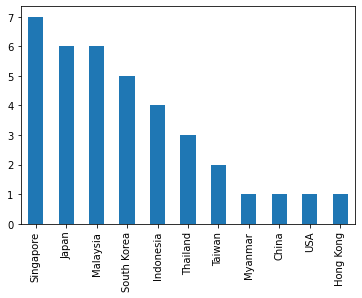

In [126]:
## Highest Top Ten Ratings
top= df[df['Top Ten Rating']>0]
top['Country'].value_counts().plot.bar()

### Interesting that Singapore was the country with the highest rating stars without being in the top 5 in terms of dominance.

In [127]:
## Plotting the Styles of which are the most popular.

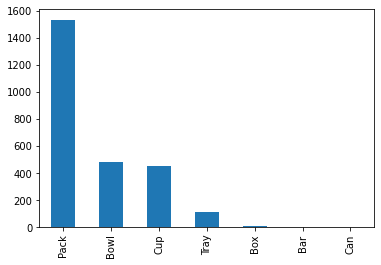

In [128]:
df['Style'].value_counts().plot.bar()

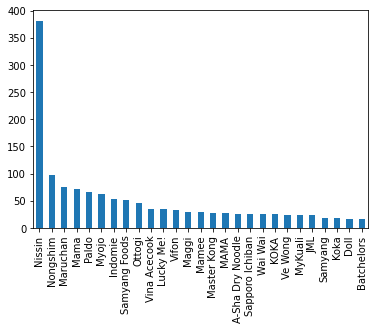

In [129]:
wow = df['Brand'].value_counts()
wow[wow>15].plot.bar()

In [130]:
# Nissin, Nongshim, Maruchan is are the dominant brands in this study.

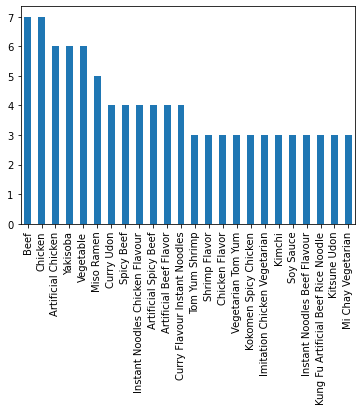

In [131]:
 new = df['Variety'].value_counts()
 new[ new>2].plot.bar()


# Word Frequency

In [132]:
df.dtypes

Review #                 int64
Brand                   object
Variety                 object
Style                   object
Country                 object
Stars                  float64
Top Ten                 object
Top Ten Rating Year    float64
Top Ten Rating         float64
dtype: object

In [133]:
df['Word_Count'] = df['Variety'].apply(lambda x: len(str(x).split(" ")))
stop_words = set(stopwords.words("english"))

In [134]:

clean_desc = []
for w in range(len(df.Variety)):
    desc = df['Variety'].iloc[w].lower()
    
    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    
    #remove tags
    desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    
    #remove digits and special chars
    desc=re.sub("(\\d|\\W)+"," ",desc)
    clean_desc.append(desc)

df['clean_desc'] = clean_desc
word_frequency = pd.Series(' '.join(df['clean_desc']).split()).value_counts()[:30]
word_frequency

noodles       675
noodle        519
instant       449
flavour       406
ramen         344
chicken       329
flavor        323
spicy         277
beef          233
cup           198
soup          197
with          170
sauce         145
rice          143
artificial    133
tom           128
shrimp        127
curry         127
mi            123
hot           120
seafood       110
bowl          104
pork          102
style          90
yum            87
goreng         79
udon           79
vermicelli     59
demae          58
oriental       58
dtype: int64

In [135]:
add_stopwords = ["noodles", "noodle","instant",'flavour','ramen','flavor','cup','with','sauce','tom','mi','yum']
stop_words = stop_words.union(add_stopwords)
print((stop_words))


{'each', "you're", "weren't", 'are', 'we', 'they', 'if', 'ours', 'from', 'yours', 'your', "wouldn't", 'itself', "she's", 'between', 'then', 'some', 'o', 'few', 'what', 'those', "don't", 'am', 'below', 'yum', "should've", 'about', 'the', 'hers', 'when', 'all', "isn't", 'nor', "shan't", 'off', 'them', 'won', 'for', 'wouldn', 'sauce', 'own', "mustn't", 'me', 'their', 'under', 'flavor', "doesn't", "won't", 'cup', 'as', 'ain', 'doing', 'than', 'ma', 'this', 'because', "wasn't", 'myself', 'or', 'until', "hadn't", 'at', "haven't", 'down', 'and', 'theirs', 'can', 'now', 'him', "aren't", 'a', 'with', 'in', 'further', 'same', 'tom', 't', 'weren', 'here', 'while', 'd', 'why', "you'll", 'just', 'should', 've', 'be', 'more', 'where', 'being', 'you', "needn't", 'ourselves', 'having', 'noodle', 'both', 'of', "you've", "didn't", 'that', 'will', 'any', 'but', 'does', 'did', 'herself', 'other', 'only', 'noodles', 'mustn', 'these', 'll', 'hadn', 'couldn', 'don', 'such', 'to', 'is', 'during', 'over', "it'

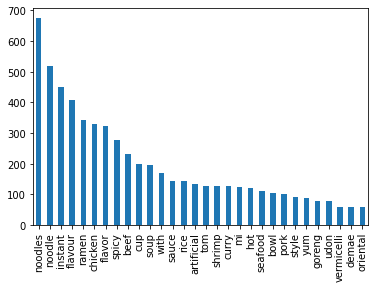

In [136]:
word_frequency.plot.bar()

### Learning to use Trigrams

In [137]:
def get_trigrams(descriptions, n=None):
    
    vec = CountVectorizer(ngram_range = (3,3), max_features = 20000).fit(descriptions)
    bag_of_words = vec.transform(descriptions)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse = True)
   
    return words_freq[:n]
#run the function on the processed descriptions
trigrams = get_trigrams(clean_desc, n=15)
#create a trigram data frame
trigram_df = pd.DataFrame(trigrams)
trigram_df.columns=["Trigram", "Freq"]
#output top 15 rows
trigram_df.head(15)


,Trigram,Freq
0,ramen noodle soup,38
1,flavour instant noodle,28
2,flavour instant noodles,25
3,style instant noodles,23
4,instant noodles chicken,22
5,oriental style instant,21
6,penang white curry,19
7,tom yum shrimp,17
8,tom yum flavour,17
9,flavor ramen noodle,16


### What I learned from Value_Counts, Trigram, Word Frequency




 Word_Frequency: Chicken, Beef, Curry

Value_Counts: Chicken, Beef, Vegetable, Yakisoba.

Trigram: Pengang White Curry, Tom Yum Shrimp, tom yum flavour are very common ingrendients in rame

# Conclusions:

### The most common ingredients in noodles are chicken, beef, or a curry flavor with yakisoba noodles.

### The top three brands that make ramen are Nissin, Nongshim, and Maruchan.

### Most of the ramen comes from Japan, but the highest rated ramen is in Singapore.